Outra biblioteca do Python -> https://lifelines.readthedocs.io/en/latest/Quickstart.html?highlight=kaplan%20meier

In [ ]:
!pip install pysurvival

In [ ]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Biblioteca para construir gráficos
import matplotlib.pyplot as plt

# Biblioteca para analise não paramétrica dos dados
from pysurvival.models.non_parametric import KaplanMeierModel

# Dados

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/derSchmetterling/analise_sobrevivencia/main/Dados/18k_Projects.csv', header=0, sep="	")
print('Data shape:', df.shape)
print('Colunas:', df.columns)
df.head()

Data shape: (18142, 35)
Colunas: Index(['Id', 'Name', 'Url', 'State', 'Currency', 'Top Category', 'Category',
       'Creator', 'Location', 'Updates', 'Comments', 'Rewards', 'Goal',
       'Pledged', 'Backers', 'Start', 'End', 'Duration in Days',
       'Facebook Connected', 'Facebook Friends', 'Facebook Shares',
       'Has Video', 'Latitude', 'Longitude', 'Start Timestamp (UTC)',
       'End Timestamp (UTC)', 'Creator Bio', 'Creator Website',
       'Creator - # Projects Created', 'Creator - # Projects Backed',
       '# Videos', '# Images', '# Words (Description)',
       '# Words (Risks and Challenges)', '# FAQs'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Id,Name,Url,State,Currency,Top Category,Category,Creator,Location,Updates,...,End Timestamp (UTC),Creator Bio,Creator Website,Creator - # Projects Created,Creator - # Projects Backed,# Videos,# Images,# Words (Description),# Words (Risks and Challenges),# FAQs
0,1007121454,Nail Art and Photos Printed on your Nails w/ E...,https://www.kickstarter.com/projects/137019948...,failed,USD,Art,Art,Dodie Egolf,Puyallup,0,...,2014/01/14 01:53:49.000,https://www.kickstarter.com/profile/1370199487,NaN,1,0.0,0.0,2,297,153.0,0
1,2032015036,Cold Again,https://www.kickstarter.com/projects/737783165...,failed,USD,Film & Video,Short Film,James Jacobs,Boston,0,...,2014/01/17 02:30:01.000,https://www.kickstarter.com/profile/737783165,NaN,1,4.0,0.0,0,276,98.0,0
2,733782855,Uchu Bijin Jewelry,https://www.kickstarter.com/projects/uchubijin...,failed,USD,Fashion,Fashion,Uchu Bijin,New York,1,...,2014/01/14 01:29:42.000,https://www.kickstarter.com/profile/858150887,http://uchubijin.com,2,2.0,0.0,12,1049,66.0,2
3,514687871,"Poetically Speaking: Stories of Love, Triumph ...",https://www.kickstarter.com/projects/tylicee/p...,failed,USD,Publishing,Poetry,Tylicee Mysreign,Detroit,0,...,2014/02/13 01:12:28.000,https://www.kickstarter.com/profile/1079088465,http://www.linkedin.com/pub/mys-reign/1a/469/4a8,1,2.0,0.0,0,309,169.0,0
4,683545993,Stranger Travels: Teachings from the Heart of ...,https://www.kickstarter.com/projects/197270300...,failed,USD,Publishing,Nonfiction,Ian Driscoll,Pucallpa,0,...,2014/01/14 01:17:46.000,https://www.kickstarter.com/profile/1972703001,http://strangertravels.wordpress.com,1,0.0,0.0,6,1636,216.0,0


In [ ]:
# resumindo a base de dados às colunas que queremos:
data = df.loc[:,['Duration in Days', 'State', 'Has Video', 'Facebook Connected', 'Facebook Shares', 'Creator Website']]
data.head()

,Duration in Days,State,Has Video,Facebook Connected,Facebook Shares,Creator Website
0,30,failed,Yes,Yes,70,NaN
1,33,failed,Yes,Yes,57,NaN
2,30,failed,No,No,158,http://uchubijin.com
3,60,failed,Yes,Yes,2,http://www.linkedin.com/pub/mys-reign/1a/469/4a8
4,30,failed,Yes,Yes,411,http://strangertravels.wordpress.com


In [ ]:
# tratamento dos dados:
data['Creator Website'] = data['Creator Website'].map(lambda x: 1 if (type(x)==str) else 0)
data['State'] = data['State'].map({'failed':0, 'successful':1})
data['Has Video'] = data['Has Video'].map({'Yes':1, 'No':0})
data['Facebook Connected'] = data['Facebook Connected'].map({'Yes':1, 'No':0})

data.head()

,Duration in Days,State,Has Video,Facebook Connected,Facebook Shares,Creator Website
0,30,0,1,1,70,0
1,33,0,1,1,57,0
2,30,0,0,0,158,1
3,60,0,1,1,2,1
4,30,0,1,1,411,1


# Modelagem Não Paramétrica

Antes de começarmos a modelagem, vamos definir certas variáveis:
* T: duração das campanhas em dias - coluna "Duration in Days";
* E: presença ou não de censura - coluna "State";
* $G_i$: indica a que grupo a observação pertence; $i=1,2,3,4$ - colunas "Has Video", "Facebook Connected", "Facebook Shares", "Creator Website";


Como vamos ajustar um modelo não paramétrico para os dados, temos que o suporte da variável T é da forma:
 $$\Theta_T = \{0; \text{ tempos observados não censurados; } \infty \}.$$

Em se tratando de código, temos:

In [ ]:
# Variáveis:
T = data['Duration in Days']
E = data['State']

# Suporte de T:
aux = data[data['State']==1]
sup = aux['Duration in Days'].unique()
del aux

sup = np.concatenate((sup, np.array([0, sup.max()+1])))
sup.sort()
sup

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [ ]:
# Inicializando o modelo Kaplan-Meier
mKM = KaplanMeierModel()

# Ajustando o modelo
mKM.fit(T, E, alpha=0.95)

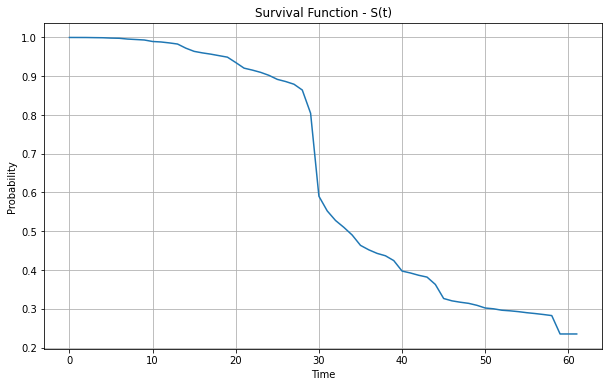

In [ ]:
# Valores estimados das funções:
fh = []
fS = []

for ano in sup:
  fh.append(mKM.predict_hazard(ano))
  fS.append(mKM.predict_survival(ano))

fh = np.array(fh)
fH = fh.cumsum()
fS = np.array(fS)
fdp = fS*fh
fda = fdp.cumsum()


# Gráfico da função de Sobrevivência:
plt.figure(figsize=(10,6))

plt.plot(sup, fS)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Survival Function - S(t)')
plt.grid()

plt.show()

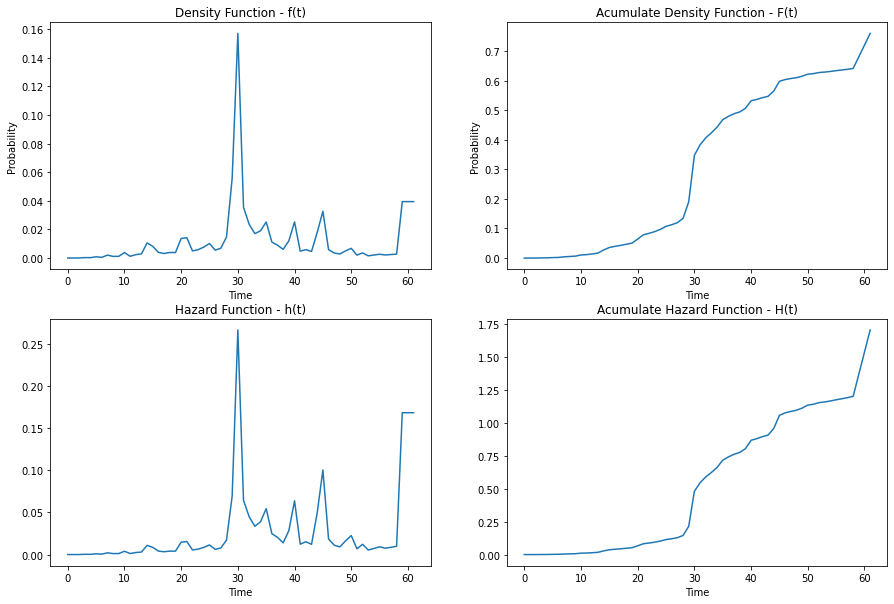

In [ ]:
# Gráficos para as funções: 
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(sup, fdp)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Density Function - f(t)')

plt.subplot(222)
plt.plot(sup, fda)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Acumulate Density Function - F(t)')

plt.subplot(223)
plt.plot(sup, fh)
plt.xlabel('Time')
plt.title('Hazard Function - h(t)')

plt.subplot(224)
plt.plot(sup, fH)
plt.xlabel('Time')
plt.title('Acumulate Hazard Function - H(t)')

plt.show()

# Medidas Resumo do Modelo

Nesta seção, iremos estimar e analisar as medidas: vida média residual, tempo de vida médio e sua prórpia variância.
Para isso, iremos precisar dos tempos distintos observados dos dados não censurados ordenados em ordem crescente, então vamos criar um vetor `t_j`, tal que:

$$\text{t_j} = \{ \mathbf{t}_{(1)}, \mathbf{t}_{(2)}, ..., \mathbf{t}_{(k)} \}, \text{ sendo k a quantidade de tempos distintos.}$$

In [ ]:
# Tempos distintos ordenados
t_j = pd.DataFrame({'Time':T, 'State':E})
t_j.sort_values(by=['Time'], inplace=True)

# Quantidade de tempos distintos não censurados
k = sup.shape[0]-2

Antes de realmente começarmos a calcular as medidas, dois vetores auxiliares são necessários, são eles:
$$n_j : \text{o número de observações sob risco no intervalo }[t_j, t_{j+1});$$
$$d_j : \text{o número de falhas no intervalo }[t_j, t_{j+1}); \text{ para j=1,...,k}.$$

In [ ]:
n_j = [t_j.shape[0]] # n_j : o numero de individuos sob risco no tempo t_j
d_j = []             # d_j : o numero de falhas no intervalo [t_j ; t_j+1)

for j in range(0, k):
    # I_j : intervalo [t_j ; t_j+1)
    I_j = t_j.query('@sup[@j+1] > `Time` >= @sup[@j]')
    #print(I_j)
    n_j.append(n_j[j]-I_j.shape[0])
    d_j.append(I_j.query('`State`==1').shape[0])

n_j = n_j[1:]

#print(n_j)
#print(d_j)
print(f'Tam(n_j) = {len(n_j)} e Tam(d_j) = {len(d_j)}.')

Tam(n_j) = 60 e Tam(d_j) = 60.


Finalmente, como visto em aula, vamos estimar o tempo de vida médio por:

$$\hat{TVM} = t_{(1)} + \sum^{k-1}_{j=1} \hat{S}(t_{j})$$

In [ ]:
# TVM
tmv = sup[1]

for j in range(2, k+1):
    tmv += (sup[j+1] - sup[j])*fS[j+1]
    
print(f'A estimativa de TVM é: TMV* = {tmv:.5f}.')

A estimativa de TVM é: TMV* = 38.32382.


In [ ]:
A2_j = lambda j: sum((sup[j+1:] - sup[j:-1])*fS[j:-1])

A2 = np.array([A2_j(j) for j in range(0, k)])
div = np.array(n_j[0:k])*(np.array(n_j[0:k])-np.array(d_j[0:k]))

Var = k/(k-1)*sum(A2/div)

print(f'E a estimativa de Var(TMV*) é: {Var:.5f}.')

E a estimativa de Var(TMV*) é: 0.00005.


In [ ]:
# Calculo da aréa sob a curva S:
auc = []
for j in range(0, k+1):
    auc.append(A2_j(j))

print(len(auc))

61


In [ ]:
# VMR
VMR = np.array(auc)/fS[:-1]
print(len(VMR))

61


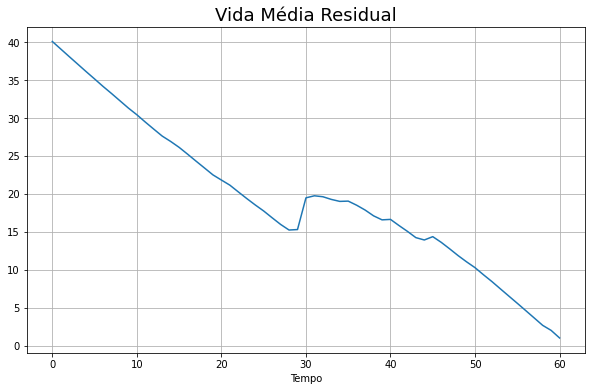

In [ ]:
# Gráficos
plt.figure(figsize=(10,6))

plt.plot(sup[:-1], VMR)
plt.title('Vida Média Residual', fontsize=18)
plt.xlabel('Tempo')
plt.grid()

plt.show()

Bom, a gente não viu como obter a mediana (e realmente, é estranho tentar obtê-la em uma função escada), mas o Koda me disse que ideia é encontrar o valor que chega mais perto.
Assim sendo, temos que: <br>

$$\hat{S}(t=33) = 0.5099 \text{   e   } \hat{S}(t=34) = 0.4902.$$

# Testes